In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [2]:
train_path = "../Computer Vision Masterclass/Datasets/cat_dog_2/training_set"
test_path = "../Computer Vision Masterclass/Datasets/cat_dog_2/test_set"

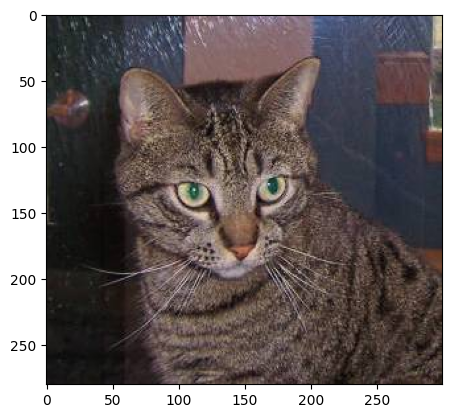

In [3]:
img = cv2.imread(train_path + "/cat/cat.1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
plt.imshow(img)

In [4]:
# ImageDataGenerator to apply data augmentation, randomly translating, rotating, resizing, etc.
train_datagen = ImageDataGenerator(rescale=1. / 255)
train_datagen.fill_mode='constant'
train_datagen.horizontal_flip=True
train_datagen.zoom_range=[0.8, 1.2]
train_datagen.rotation_range=20
train_datagen.shear_range=10
train_datagen.brightness_range = [0.75, 1.5]



#making image as 227X227 for input of alexnet
# train = train_datagen.flow_from_directory(train_path, target_size=(227,227), class_mode='categorical')
train = train_datagen.flow_from_directory(train_path, target_size=(64, 64), shuffle=True, class_mode='categorical')


Found 4000 images belonging to 2 classes.


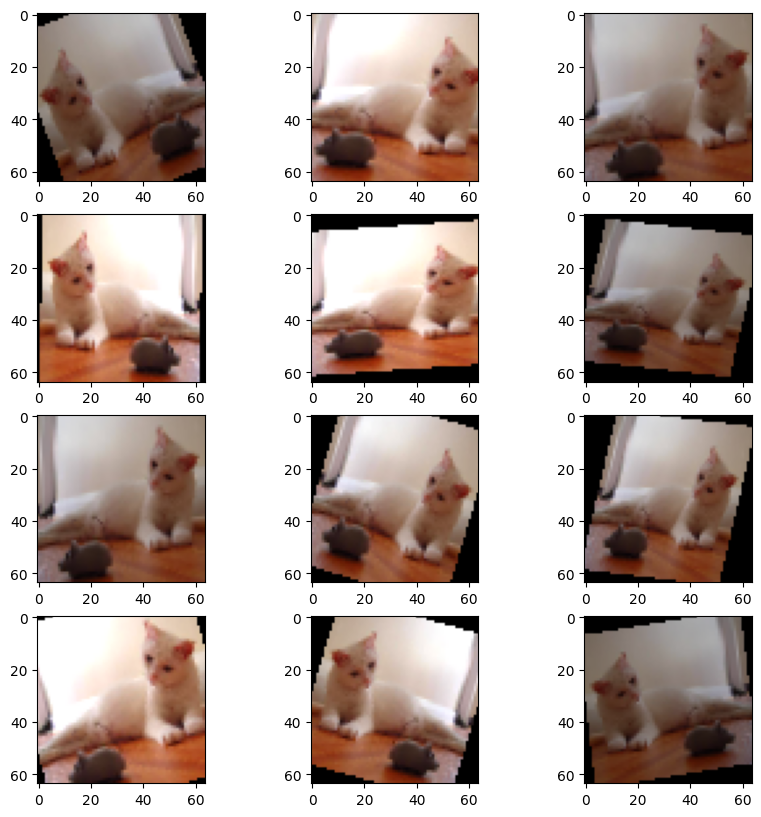

In [5]:
fig , axs = plt.subplots(4,3 ,figsize = (10,10))

axs[0][0].imshow(train[1][0][0])
axs[0][1].imshow(train[1][0][0])
axs[0][2].imshow(train[1][0][0])
axs[1][0].imshow(train[1][0][0])
axs[1][1].imshow(train[1][0][0])
axs[1][2].imshow(train[1][0][0])
axs[2][0].imshow(train[1][0][0])
axs[2][1].imshow(train[1][0][0])
axs[2][2].imshow(train[1][0][0])
axs[3][0].imshow(train[1][0][0])
axs[3][1].imshow(train[1][0][0])
axs[3][2].imshow(train[1][0][0])

In [6]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test = test_datagen.flow_from_directory(test_path, target_size=(64,64), shuffle=False, class_mode='categorical')

Found 1000 images belonging to 2 classes.


In [12]:
def resnext_block(X, filters, cardinality, strides=1):
    group_list = []

    # Shortcut path
    shortcut = X

    # Split the input into multiple groups
    for i in range(cardinality):
        group = Conv2D(filters // cardinality, kernel_size=(1, 1), strides=strides, padding='same')(X)
        group = BatchNormalization()(group)
        group = Activation('relu')(group)

        group = Conv2D(filters // cardinality, kernel_size=(3, 3), padding='same')(group)
        group = BatchNormalization()(group)
        group = Activation('relu')(group)

        group = Conv2D(filters, kernel_size=(1, 1), padding='same')(group)
        group = BatchNormalization()(group)
        
        group_list.append(group)

    # Merge groups
    if len(group_list) > 1:
        X = Add()(group_list)
    else:
        X = group_list[0]

    # # Shortcut path
    # shortcut = X

    # Add shortcut to the main path
    X = Add()([X, shortcut])
    X = Activation('relu')(X)

    return X


def ResNeXt(input_shape=(64, 64, 3), classes=2, cardinality=8):
    X_input = Input(input_shape)

    # Initial Conv Layer
    X = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # ResNeXt Blocks
    X = resnext_block(X, filters=128, cardinality=cardinality, strides=1)
    X = resnext_block(X, filters=256, cardinality=cardinality, strides=2)
    X = resnext_block(X, filters=512, cardinality=cardinality, strides=2)

    # Average Pooling
    X = GlobalAveragePooling2D()(X)

    # Output layer
    X = Dense(classes, activation='softmax')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNeXt')

    return model


network = ResNeXt(input_shape=(64, 64, 3), classes=2, cardinality=4)

network.summary()


Model: "ResNeXt"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64,    │      2,080 │ activation_28[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 64, 64,    │      2,080 │ activation_28[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 64, 64,    │      2,080 │ activation_28[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 64, 64,    │      2,080 │ activation_28[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_52[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 64, 64,    │      9,248 │ activation_29[0]

 Total params: 1,320,194 (5.04 MB)

 Trainable params: 1,309,314 (4.99 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [13]:
# Define the learning rate you want to use
learning_rate = 0.0001  # Example learning rate

# Instantiate the Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile your neural network model with the customized optimizer
network.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = network.fit(train, epochs=20)

Epoch 1/20


d:\D-Program Files\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 117s 854ms/step - accuracy: 0.5804 - loss: 0.8038
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 853ms/step - accuracy: 0.6259 - loss: 0.6547
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 106s 848ms/step - accuracy: 0.6538 - loss: 0.6323
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 106s 844ms/step - accuracy: 0.6614 - loss: 0.6187
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 106s 842ms/step - accuracy: 0.6635 - loss: 0.6096
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 831ms/step - accuracy: 0.6809 - loss: 0.5969
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 824ms/step - accuracy: 0.7068 - loss: 0.5748
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 822ms/step - accuracy: 0.7031 - loss: 0.5590
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 824ms/step - accuracy: 0.7036 - loss: 0.5759
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 830ms/step - accuracy: 0.7049 - loss: 0.5657
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 822ms/step - accuracy: 0.7121 - loss: 0.5488
Epoch 12/20
125/125

In [15]:
predictions = network.predict(test)
predictions

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step


array([[0.5448276 , 0.45517245],
       [0.3963762 , 0.6036238 ],
       [0.50819135, 0.4918086 ],
       ...,
       [0.00257369, 0.99742633],
       [0.05934684, 0.9406532 ],
       [0.02854954, 0.9714505 ]], dtype=float32)

In [16]:
# predicted values
predictions = np.argmax(predictions, axis=1)
predictions 

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,

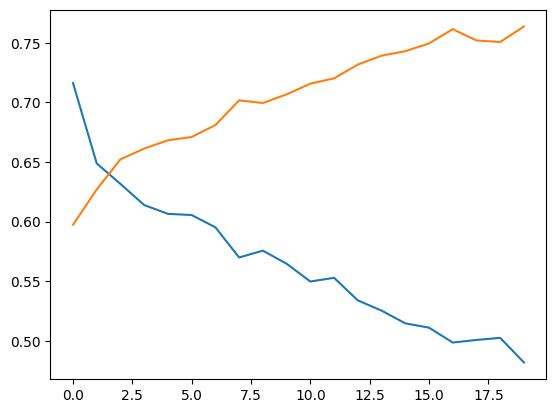

In [17]:
plt.plot(history.history['loss'] )
plt.plot(history.history['accuracy'] )

In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(test.classes, predictions)

0.665